# Pulling in Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from pylab import rcParams
rcParams['figure.figsize'] = 50, 20
import nltk
from nltk.corpus import stopwords
import re
import time
start=time.time()
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/coreyyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Pulling in the data, cleaning it, and organizing it for use

In [2]:
# Pull in data

work_ex = pd.read_csv('car_muse.csv').dropna()
skills = pd.read_csv('skills.csv').dropna()

# Make dataframe of work_ex with only the first instance of job title
grpdby_title = work_ex[['resume_id', 'title', 'description']].groupby('resume_id').first()

In [3]:
# Add space in front of each skill to prepare for group-by

listy = []
for i in skills['value']:
    listy.append(' ' + i)
skills['value'] = listy

In [4]:
# Group skills table by resume_id

grpd_skills = skills[['resume_id', 'value']].groupby('resume_id').sum()

In [5]:
# Merge the two tables into new dataframe, fill na with empty string to bypass errors downstream

merged = grpdby_title.merge(grpd_skills, how='outer', left_index=True, right_index=True).fillna('')
merged.columns = ['title', 'description', 'skills']

In [6]:
# Create dataframe for each job title by repeating above steps

merged = grpdby_title.merge(grpd_skills, how='outer', left_index=True, right_index=True)
merged.columns = ['title', 'description', 'skills']
merged = merged[pd.notnull(merged['title'])]
merged.fillna('', inplace=True)

In [7]:
top_titles = merged['title'].str.lower().str.strip().value_counts().index[:2910]

In [8]:
for_jt_mat = merged[merged['title'].str.strip().str.lower().isin(top_titles)]

In [9]:
for_jt_mat['title'] = for_jt_mat['title'].str.strip().str.lower()
for_jt_mat['title'].value_counts()
sample2 = for_jt_mat.groupby('title').sum()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
# Functions from Jesse to clean skills data and make a vocabulary for skills vectorization

def text_scrubber(values):
    
    '''
        Replace problematic phrases and unicode characters.
        
        (10+ years) ---> ''
        &#39; , \x92 ---> apostrophe
        Technical: ---> ''
        
        These characters act usually as separators, so replace them with commas for splitting later.
            [:, ;, &amp;, \x95, &, ., /, 'and'] ---> ','
        
    '''

    result = []
    for string in values:
        # Regex as explained above
        temp = re.sub('(\(.*\))', '', string)
        temp = re.sub('&#39;|\x92', '\'', temp)
        temp = re.sub(' &amp; |&amp;|\x95|:|;|&|\.|/| and ', ',', temp)
        temp = re.sub('\w*:\s+', ', ', temp)
        
        result.append(temp)
        
    return result



def tokenizer(df):
    
    
    '''
        Parse the given skills dataframe to pull out appropriate skill phrases.
        Dataframe has some cells that are 2-gram nicely made skills, and other cells
        that are long runons with many skills.
        After scrubbing and then splitting on commas, we simplify the task by tossing
        out any greater than 4-gram phrases. 
    '''
    
    # Custom stop words that come up very often but don't say much about the job title.
    stops = ['manager', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily',
             'services', 'job', 'using', '.com', 'end', 'prepare', 'prepared', 'lead', 'requirements','#39'] + list(stopwords.words('english'))
    values, ids, resume_ids = [],[],[]
    count = 0
    for idx, row in df.iterrows():
        
        # Split on commas
        array = row['skills'].lower().split(',')
        for x in array:
            # make sure the value is not empty or all numeric values or in the stop words list
            if x != '' and not x.lstrip().rstrip() in stops and not x.lstrip().rstrip().isdigit():
                # make sure single character results are the letter 'C' (programming language)
                if len(x) > 1 or x == 'C':
                    # drop stuff > 4 gram
                    if len(x.split(' ')) <= 4:
                        # update lists
                        
                        values.append(x.lstrip().rstrip())
                        ids.append(count)
                        count+=1
    
    # New dataframe with updated values.
    result_df = pd.DataFrame()
    
    result_df['skills'] = values
    return result_df

df = sample2.copy()

df['skills'] = text_scrubber(df['skills'])
test_df = tokenizer(df)

voc = test_df['skills'].unique()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


# Vectorizing job descriptions and skills for features

In [11]:
# Vectorize text of job descriptions, put resulting matrix into dataframe
sample2['description'] = [x.replace("&nbsp;"," ").replace("\x92"," ").replace("\x95"," ").replace('&amp;'," ") \
                             .replace('*'," ").replace("."," ").replace("co&#39;s","").replace("\xae&quot;","") \
                             .replace("&#39;s","").replace("&quot;","").replace("?","").replace("&#39;s","") \
                             .replace("@","").replace("\x96","")
                             for x in sample2['description']]

mine = ['manager', 'amp', 'nbsp', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily',
       'services', 'job', 'using', 'com', 'end', 'prepare', 'prepared', 'lead', 'requirements']
vec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern='[a-zA-z]{3,50}', max_df=0.2, min_df=2,
                      max_features=10000, stop_words=text.ENGLISH_STOP_WORDS.union(mine), decode_error='ignore', vocabulary=None, binary=False)

description_matrix2 = vec.fit_transform(sample2['skills']+sample2['description'])
description_matrix2 = pd.DataFrame(description_matrix2.todense())
description_matrix2.columns = vec.get_feature_names()

In [12]:
# Vectorize skills text with scrubby as vocab, put resulting matrix into dataframe
vec2 = TfidfVectorizer(vocabulary=voc, decode_error='ignore')
skills_matrix2 = vec2.fit_transform(sample2['skills']+sample2['description'])
skills_matrix2 = pd.DataFrame(skills_matrix2.todense())
skills_matrix2.columns = vec2.get_feature_names()



In [13]:
# Combine skills and description matrices into combined job title feature matrix

jobtitle_matrix = pd.concat([skills_matrix2, description_matrix2], axis=1)

In [14]:
jobtitle_matrix.head(3)

//anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:1237: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


,personnel administration,labor,employment laws,staff recruitment,training,organizational management,employee relations,conflict resolution,regulatory compliance,powerpoint,...,youth,youtube,yoy,yrs,ytd,zendesk,zero,zip,zone,zoning
0,0.0,0.091733,0.0,0.0,0.303941,0.0,0.0,0.0,0.0,0.065525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.067620,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Run PCA to reduce number of features for clustering, logistic regression, and cosine similarity calculations
Ideally, this would run on a scheduled basis as more data came in to train the model

In [15]:
# Run PCA to reduce number of features

pca = PCA(n_components=1000, random_state=42)
comps = pca.fit_transform(jobtitle_matrix)

In [16]:
# Put the components into a dataframe

comps = pd.DataFrame(comps)

# Cluster data into similar titles to increase efficiency of cosine similarity calculations

In [17]:
# Cluster job titles based on components derived from feature matrix

cltr = AgglomerativeClustering(n_clusters=8)
cltr.fit(comps)

# Add new column containing cluster number to sample, comps, and feature matrix dataframes

sample2['cluster_no'] = cltr.labels_

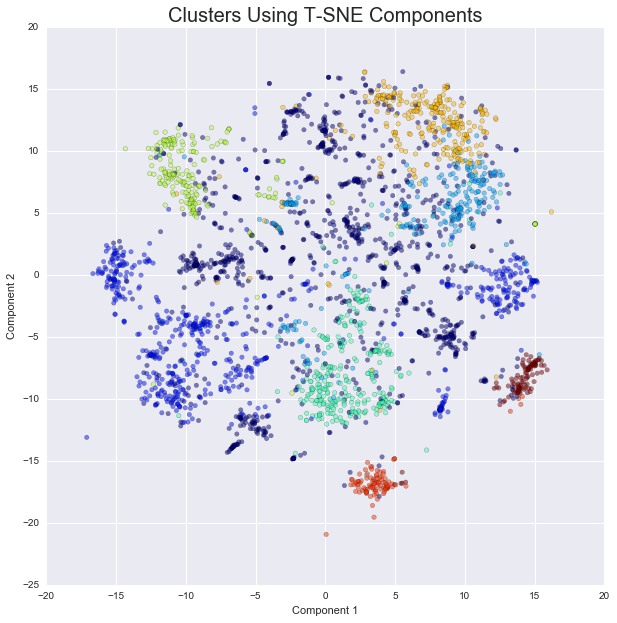

In [30]:
# Look at clusters

from sklearn.manifold import TSNE

tsne = TSNE()
g = pd.DataFrame(tsne.fit_transform(comps), columns=['one', 'two'])


g['cluster_no'] = cltr.labels_

import matplotlib.cm as cm

plt.figure(figsize=(10,10))
plt.title('Clusters Using T-SNE Components', fontsize=20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(g['one'], g['two'], c=g['cluster_no'], cmap=cm.jet, alpha=0.5)

plt.show()

# Train multinomial logistic regression to assign clusters to incoming users

In [19]:
# Assign X, y, and the train test split
X = comps
y = sample2['cluster_no']

In [20]:
# Test logistic regression
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.86538461538461542

In [21]:
# Fit logistic regression to entire data
lr.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# Assign cluster number to each job title in comps to pull particular cluster out for comparison
comps['cluster_no'] = y.values
comps.set_index('cluster_no', inplace=True)

# Suggest jobs based on user resume text

In [23]:
# Putting resume as text into the system for suggestions
resume_text = '''
Matt Brown
Student - Data Science Immersive at General Assembly
m.brown3255@gmail.com
Summary
I am currently taking a 3 month leave of absence from Amazon to take the full-time Data Science Immersive course at General Assembly (full details in experience below) while continuing to learn online (Treehouse + Udemy + Codecademy) with the goal to come back working as a data professional.
I am very passionate about using data to increase productivity/automation and create better customer experiences. Before this course and working at Amazon, I worked at Target.com, Sears.com, and a web analytics/big data start up, Dataium (acquired by IHS; NYSE). I went to school at Indiana University where I majored in Marketing/Operations, was a Teacher Assistant for a business course called Technology in Business, and started a cake delivery company (MyCampusCakes.com, more details below) where we delivered cakes to students on their birthdays (typically ordered by their parents).
Experience
Student - Data Science Immersive at General Assembly
October 2016 - Present (3 months)
General Assembly - Data Science Immersive is a 3-month full-time in-person course that teaches the skills
required to become a Data Scientist including Python, SQL, Mongo-DB, Machine Learning Modeling (classification, regression, and clustering) , Tableau, etc.
Full information regarding this course can be found at the below link:
https://generalassemb.ly/education/data-science-immersive
Brand Specialist - Video Games, Shoes at Amazon
February 2014 - October 2016 (2 years 9 months)
Brand Specialist in Video Games on the Microsoft account (Xbox, Halo/Gears of War/Minecraft, Digital,
etc.). Responsible for Marketing/Site Experiences, Inventory Management/Supply Chain, Digital selection/ CX growth, and project roll outs. Was previously on the Rockport shoes account until June 2015.
Senior Business Analyst - Target.com at Target
June 2012 - February 2014 (1 year 9 months)
• Managed $50M+ worth of inventory flow and instocks for Entertainment (Movies, Music, and Books) and
  Girls Toys for Target.com.
Page1
• Invented new process and analytics suite to predict store new release sales using online real-time web analytics metrics resulting in increased buys on key new release titles and the SVP and VP Multichannel Merchandising Awards.
• Created and trained Target.com merchandising team on web analytics suite Adobe Site Catalyst (Omniture) • Provided Ad Hoc reporting for Buyers and extended team for sales, inventory, and web analytics metrics.
Owner, Co-Founder at MyCampusCakes.Com
February 2011 - June 2012 (1 year 5 months)
Co-founded MyCampusCakes.Com with my college roommate. MyCampusCakes.com was a website/ service that allowed parents of students at Indiana University to send their student a birthday cake/cupcakes,
balloons/utensils, and a card/note to their door! Check out the article below written about our launch on the front page of our student newspaper, the IDS!
IHSAA Basketball Referee at IHSAA
December 2010 - June 2012 (1 year 7 months)
I am a licensed IHSAA basketball referee and I ref anywhere from Kindergartners to High School to Mens'
League games.
X201 Technology in Business: Teaching Assistant at Kelley School of Business
December 2010 - May 2012 (1 year 6 months)
• Selected by faculty and other teaching assistants to guide 30+ students on in-class Excel projects and
coursework.
• Led five project review sessions, two practical review sessions, and proctored final exams • Held weekly office hours to help 20+ students on course material
• Created and updated supplementary Excel review files for student’s exam preparation
Buyer Apprentice Intern - Online Consumer Electronics at Sears Holdings Corporation
May 2011 - August 2011 (4 months)
• Developed 2 dynamic user-friendly Excel Dashboard tools that automatically determine online TV and
Tablet assortment gaps of over 2,100 SKU’s.
• Created a project path diagram and financial forecasting spreadsheet of over 55,000 Marketplace SKU’s and
$106,000 in incremental revenue.
Summer Analyst at Dataium
May 2010 - August 2010 (4 months)
• Learned the ins and outs of web analytics including cookie-gathering, click maps, and click analytics (visits,
LTV ratio, page views, click thru rate, conversion, bounce rate, exit/entry pages, referral traffic, conversional
funnels, etc) of over 4 million unique users.
• Worked with website developers to analyze click-maps of over 100 domains. • Utilized Salesforce.Com to find, shift, and coordinate over 3,000 leads.
• Completed web technology audits for several hundred websites.
Page2
Mens Basketball League Coordinator at Lifetime Fitness
December 2006 - July 2009 (2 years 8 months)
Helped determine scheduling, pricing, stats, and processing for the Mens Basketball League at Lifetime
Fitness.
Honors and Awards
SVP and VP Multichannel Merchandising Award
Target Corporation September 2013
Utilized site analytics and pre-orders to predict store sales resulting in increased buys on key entertainment titles that ended up over-performing in stores during its street week sales.
Divisional Thought Leadership Award
Target Corporation February 2013
Enhanced Target.com Exclusive Entertainment SKU process resulting in increased pre-orders via assortment parity with the stores, longer pre-order windows, increased instocks, internal search optimization, and increased PDP content.
Skills & Expertise
Analysis
SQL
Python
Microsoft Excel Tableau
MongoDB E-commerce Online Advertising PowerPoint Leadership
Data Analysis
Strategic Planning Sales
Market Research Inventory Management Microsoft Office Project Management Digital Strategy
Public Speaking Event Planning Analytics Merchandising
  Page3
VBA
Social Media Marketing Retail
Management
Process Improvement Microsoft Word
Social Media
Time Management
Web Analytics Functions
Financial Analysis Social Networking Critical Thinking Spreadsheets Accounting
User Interface
Account Management Statistics
Business
Pricing
Marketing Analytics HTML
Macro
Pivot Tables
Teamwork
Financial Modeling
Education
General Assembly
Data Science Immersive, 2016 - 2016
Indiana University Bloomington
Bachelor of Science in Business, Marketing and Operations - Kelley School of Business, 2008 - 2012
Interests
Internet of Things, Voice AI (Alexa/Echo, Google Home, etc), Action-Leading Business Intelligence, E- commerce, Basketball, and Video Games.
Projects
Halo 5 Tableau Dashboard
October 2016 to Present Members:Matt Brown
   Page4
This is a Tableau Dashboard I created for my personal Halo 5 (video game) stats. I've always wanted to be able to easily filter by a time-frame and see the most important statistics including Win-Loss Record, Kill/
Death Ratio, Top Games, Kill/Death Ratio over time, etc.
I created this by plugging into the Halo 5 Public API (https://developer.haloapi.com), data munging with python, and feeding into Tableau.
Courses
Independent Coursework
Python Basics - TeamTreeHouse.com
SQL Basics & Modifying Data with SQL - TeamTreeHouse.com
Python - CodeCademy.com
Learn SQL - CodeCademy.com
Learn GIT - CodeCademy.comf
Certifications
  Try SQL
Code School
Python
Codecademy
Learn SQL
Codecademy
Learn GIT
Codecademy
SQL Basics
Treehouse Inc.
November 2016
November 2016
October 2016
October 2016
October 2016
Modifying Data with SQL
Treehouse Inc. October 2016
Reporting with SQL
Treehouse Inc. October 2016
 Page5
Matt Brown
Student - Data Science Immersive at General Assembly
m.brown3255@gmail.com
Contact Matt on LinkedIn
          Page6

'''

# Vectorize user's skills and job descriptions
desc = pd.DataFrame(vec.transform([resume_text]).todense())
skillz = pd.DataFrame(vec2.transform([resume_text]).todense())
mat = pd.concat([skillz, desc], axis=1)

# Tranform feature matrix with pca
user_comps = pd.DataFrame(pca.transform(mat))

# Predict cluster for user and print cluster number
cluster = lr.predict(user_comps)[0]
print 'CLUSTER NUMBER', cluster, '\n\n'

# Calculate cosine similarity
cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==cluster]))

# Get job titles from sample2 to associate cosine similarity scores with jobs
samp_for_cluster = sample2[sample2['cluster_no']==cluster]
cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
cos_sim.columns = ['score']

# Print the top ten suggested jobs for the user's cluster
print 'Top ten suggested for your cluster', '\n', cos_sim.sort_values('score', ascending=False)[:10], '\n\n'

# Print the top five suggested jobs for each cluster
for i in range(8):
    cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==i]))
    samp_for_cluster = sample2[sample2['cluster_no']==i]
    cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
    cos_sim.columns = ['score']

    print 'Top five suggested in cluster', i,  '\n', cos_sim.sort_values('score', ascending=False)[:5], '\n\n'

CLUSTER NUMBER 0 


Top ten suggested for your cluster 
                                                       score
title                                                       
senior product marketing manager - advertising/...  0.322704
assistant professor                                 0.227370
product management consultant                       0.216605
business data analyst                               0.215338
senior marketing research analyst                   0.195968
research                                            0.189611
advertising consultant for cars                     0.181113
internship                                          0.178523
teacher                                             0.177694
senior product manager, retail leadership devel...  0.177008 


Top five suggested in cluster 0 
                                                       score
title                                                       
senior product marketing manager - advertising/...  0.

# Testing for printing skills for suggested jobs

In [24]:
resume_text = '''
Certified Professional in Human Resources (PHR) with additional state certification in California (PHR-CA) offering a 14-year HR career distinguished by commended performance and proven results.
Extensive background in HR generalist affairs, including experience in employee recruitment and retention, staff development, mediation, conflict resolution, benefits and compensation, HR records management, HR policies development and legal compliance.
Demonstrated success in negotiating win-win compromises, developing teambuilding programs, and writing personnel manuals, corporate policies, job descriptions and management reports. 
HR SKILLS
Staff Recruitment & Retention
Employee Relations
Alternative Dispute Resolution (ADR)
Benefits Administration
HR Program/Project Management
Orientation & On-Boarding
HRIS Technologies
Training & Development
Performance Management
Organizational Development
PROFESSIONAL EXPERIENCE
ABC COMPANY -- Los Angeles, CA
Provides voice and data communications systems for small and mid-sized companies.

HR Generalist, 2002-present
Recruited to help open new company branch in Los Angeles, guiding the startup and management of a full spectrum of HR operations, systems and programs. Worked with senior management to create HR policies and procedures; recruit employees; create group benefits databases; and develop orientation, training and incentive programs. Manage leave-of-absence programs and personnel records; administer benefits enrollment and programs; administer HR budget; and handle HR generalist workplace issues.

Key Results:

Played a key role in ensuring the successful launch of Los Angeles office. Structured and implemented programs and policies in the areas of training, compensation structures, benefits packages, incentives and new-employee orientation.
Fostered a teamwork/open-door environment conducive to positive dialogue across the organization. Personal efforts were cited as the driving force behind branch's employee-retention rate of 89% within an industry where high turnover is the norm.
Negotiated approximately 50 salary offers and dozens of sign-on bonuses/relocation packages annually at both the exempt and nonexempt level.
Brought workers' compensation program into full compliance. Instituted preferred providers list and trained managers and associates on procedures to follow in case of injury.
Reduced benefits costs by 15% annually through meticulous recordkeeping and ensuring that company did not pay for benefits for which employees were ineligible.
Wrote employee manual covering issues including disciplinary procedures, code of conduct, FMLA policy and benefits information.
Introduced company's first formal performance review program, creating a flexible and well-received tool that was later adopted company-wide.
Revised job descriptions across all levels and 50+ categories. "Shadowed" and interviewed employees to construct an accurate picture of the duties and skills required for each position.
DEF COMPANY -- Lake Forest, CA
Leading home healthcare company employing 4,500 professionals.

HR Representative, 1997-2002
HR Assistant, 1995-1997

Promoted to fulfill a broad range of HR functions, including recruiting and training employees, administering benefits, overseeing disciplinary action and managing HR records. Co-chaired annual flex-enrollment meetings, resolved conflicts between employees and insurance carriers, coordinated health fairs to promote employee wellness and performed exit interviews.

Key Results:

Trained 25-member management team on interviewing techniques and best practices, conducting workshops and one-on-one coaching sessions that contributed to sound hiring decisions.
Co-developed company's first-ever standardized disciplinary procedures and tracking system that insulated company from legal risk and ensured consistent and fair discipline processes.
Devised creative and cost-effective incentive and morale-boosting programs (including special events and a tiered awards structure) that increased employee satisfaction and productivity.
Reworked new-hire orientation program to include HR information and company resources.
Saved company thousands of dollars every month by reducing reliance on employment agencies. Brought the majority of formerly outsourced recruiting functions in-house to reduce billable hours from 200+ to less than 15 per month. 
EDUCATION & CERTIFICATIONS
CALIFORNIA STATE UNIVERSITY -- Northridge, CA
Bachelor of Arts (BA) in Psychology (with honors), 1994
Activities: Worked concurrently during college as a sales rep and team supervisor for ABC Video Store.

HR Designations:

PHR-CA (Professional in Human Resources with CA state-specific certification), 2001
PHR (Professional in Human Resources), 1999
OF NOTE
Professional Development:

Complete ongoing training in the areas of compensation and benefits, employee and labor relations, leaves of absence, workers' compensation and workplace safety/security.
Affiliations:

Society for Human Resource Management (SHRM)
Staffing Management Association (SMA) of Southern CA
Computer Skills:

HRIS applications (UltiPro, PeopleSoft Enterprise Human Resources, ADP)
MS Office (Word, Excel, PowerPoint, Access, Outlook)
'''

In [25]:

def give_suggestions(resume_text):
    # Vectorize user's skills and job descriptions
    desc = pd.DataFrame(vec.transform([resume_text]).todense())
    desc.columns = vec.get_feature_names()
    skillz = pd.DataFrame(vec2.transform([resume_text]).todense())
    skillz.columns = vec2.get_feature_names()
    mat = pd.concat([skillz, desc], axis=1)

    # Tranform feature matrix with pca
    user_comps = pd.DataFrame(pca.transform(mat))

    # Predict cluster for user and print cluster number
    cluster = lr.predict(user_comps)[0]
    print 'CLUSTER NUMBER', cluster, '\n\n'

    # Calculate cosine similarity
    cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==cluster]))

    # Get job titles from sample2 to associate cosine similarity scores with jobs
    samp_for_cluster = sample2[sample2['cluster_no']==cluster]
    cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
    cos_sim.columns = ['score']

    # Print the top ten suggested jobs for the user's cluster
    print 'Top ten suggested for your cluster', '\n', cos_sim.sort_values('score', ascending=False)[:10], '\n\n'

    # Print the top five suggested jobs for each cluster
    mat = mat.T
    for i in range(8):
        cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==i]))
        samp_for_cluster = sample2[sample2['cluster_no']==i]
        cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
        cos_sim.columns = ['score']
        top_5 = cos_sim.sort_values('score', ascending=False)[:5]

        # Merge top_5 with sample2 to get skills and description
        merged_top_5 = top_5.merge(sample2, how='left', left_index=True, right_index=True)
        print '---------Top five suggested in cluster', i,  '---------\n', top_5, '\n\n'
        # Vectorize to find skills needed for each job title

        for job in merged_top_5.index:
            job_skills = pd.DataFrame(vec2.transform([merged_top_5.ix[job]['description']+merged_top_5.ix[job]['skills']]).todense())
            job_skills.columns = vec2.get_feature_names()
            job_skills = job_skills.T
            job_skills.columns = ['score']
            job_skills = job_skills[job_skills['score'] != 0].sort_values('score', ascending=False)
            mat.columns = ['score']
            mat = mat[mat['score'] != 0]
            needed_skills = []
            scorey = []
            for i in job_skills.index:
                if i not in mat.index:    
                    needed_skills.append(i)
                    scorey.append(job_skills.ix[i][0])
            top_skills = pd.DataFrame(zip(needed_skills, scorey), columns=['Skills', 'Importance'])
            print 'To become a/an', job+',', '\n', 'these are the top ten skills you need:', '\n'
            print top_skills[:10], '\n'
        
            
        
    

In [26]:
give_suggestions(resume_text)

CLUSTER NUMBER 7 


Top ten suggested for your cluster 
                                      score
title                                      
human resource manager             0.729584
human resources manager            0.717719
human resources generalist         0.713582
director of human resources        0.708348
director, human resources          0.705052
human resources director           0.690655
regional human resources manager   0.682575
human resources representative     0.680227
vice president, human resources    0.670053
vice president of human resources  0.662898 


---------Top five suggested in cluster 0 ---------
                                             score
title                                             
human resource consultant                 0.439809
human resources team member               0.291757
hr specialist                             0.278948
administrative assistant/human resources  0.232625
payroll administrator                     0.220168 


To

In [27]:
print time.time()-start

116.306721926
